## Transfer Learning

Na prática, treinar uma rede convolutiva a partir do zero (com inicialização aleatória), é relativamente raro (conjunto de dados de tamanho suficiente)



Modelos para classificação de imagens com pesos treinados em ImageNet (disponível em Keras)
    * Xception
    * VGG16
    * VGG19
    * ResNet50 
    * InceptionV3
    * InceptionResNetV2
    * MobileNet 
    * DenseNet
    * NASNet
https://keras.io/applications/    

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/My Drive/BI-Temp' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

Mounted at /content/drive


In [2]:
!pip install keras_tqdm
from keras.models import Sequential, Model,load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
import numpy as np
import keras
from keras.applications.vgg16 import VGG16
from PIL import Image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
from keras import losses
from tensorflow.keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from random import randint
import matplotlib.pylab as plt

## Definir uma rede VGG16  (Oxford-2014) 

http://www.robots.ox.ac.uk/~vgg/research/very_deep/

Os vencedores do ILSVRC 2014

http://www.image-net.org/challenges/LSVRC/


O conjunto de dados inclui imagens de 1000 classes e é dividido em três conjuntos (rótulada): 
    
    * Treinamento (imagens 1.3M)
    * Validação (imagens 50K)
    * Testes (imagens de 100K).

``` python
def  VGG_16():
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'))
    model.add(Conv2D(64,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))
    model.add(Conv2D(128,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(Conv2D(128,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(MaxPooling2D((2,2),strides=(2,2)))    
    model.add(Conv2D(256,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(Conv2D(256,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(Conv2D(256,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(MaxPooling2D((2,2),strides=(2,2)))     
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(MaxPooling2D((2,2),strides=(2,2)))      
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(MaxPooling2D((2,2),strides=(2,2)))
    model.add(Flatten())
    # Camada superior
    model.add(Dense(4096,activation='relu'))
    model.add(Dense(4096,activation='relu'))
    model.add(Dense(1000,activation='softmax'))
    return model
```

## Carregando a rede VGG16 com os pesos treinados

In [3]:
model_vgg16= VGG16(weights="imagenet", include_top=True)
# weights: carrega com os pesos já calculados, isto é, rede já treinada
# top é a fullt connected
model_vgg16.summary()
#output Nome: ainda nao recebeu nenhuma imaggem
# a saída é 1000, pois é a quantidade de classes da rede

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [4]:
for i, layer in enumerate(model_vgg16.layers):
    print(i , layer.name, layer.output_shape)

0 input_1 [(None, 224, 224, 3)]
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
6 block2_pool (None, 56, 56, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
10 block3_pool (None, 28, 28, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
14 block4_pool (None, 14, 14, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)
18 block5_pool (None, 7, 7, 512)
19 flatten (None, 25088)
20 fc1 (None, 4096)
21 fc2 (None, 4096)
22 predictions (None, 1000)


## Reconhecendo trens com a rede VGG16

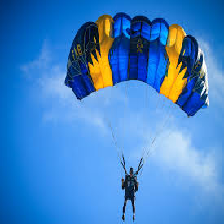

In [5]:
# Carregando uma nova imagen
imagem=load_img('paraquedas.jpg', target_size=(224,224,3));imagem

In [6]:
# Transformando a imagem para um tipo array
img_array=img_to_array(imagem).astype('float32')
img_array=img_array.reshape((1,224,224,3));img_array.shape

(1, 224, 224, 3)

In [7]:
# Evaluando o modelo VGG16
# a rede ja estava treinada 
#otimizer=SGD(lr=0.1,decay=1e-6,momentum=0.9,nesterov=True)
#model_vgg16.compile(optimizer=otimizer,loss='categorical_crossentropy')
saida=model_vgg16.predict(img_array)
print("Classe   : ",np.argmax(saida),"\nPrevisão :",np.max(saida))

Classe   :  701 
Previsão : 0.99396086


classes:


https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

Jeito 1: vai pegar só as convulocionais

## Utilizar uma rede pre-treinada para extrair "features"

Os modelos pre-treinados tem que aprender características (features) das imagens que são aprendidos para diferenciar uma imagem de uma classe de outra classe.

    * Remover as camadas full conected do modelo pre-treinado.
    * Rodar imagens do dataset na rede Truncada para obter "features" do dataset
    * Utilizar os "features" como entrada em outra rede "full conected".

# Extraindo "features"

In [8]:
# jeito 1, só vai pega a pre=treinada
# Truncar a rede VGG16
model=Model(inputs=model_vgg16.input,outputs=model_vgg16.get_layer('block5_pool').output)
model.summary()

# o tamanho daa saída é (None, 7, 7, 512)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

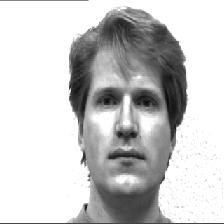

In [9]:
# Carregando uma nova imagen
imagem=load_img('yalefaces/subject1/subject01.normal.jpg', target_size=(224,224,3));imagem
#imagem=load_img('subject01.normal.jpg', target_size=(224,224,3));imagem

In [10]:
# Transformando a imagem para um tipo array
img_array=img_to_array(imagem).astype('float32')
img_array=img_array.reshape((1,224,224,3))
x=preprocess_input(img_array)

In [11]:
# Obter Caracteristicas de um dado
features=model.predict(x);features.shape
# conferir que é o shape da saída do modelo, que é 
#block5_pool (MaxPooling2D)  (None, 7, 7, 512)

(1, 7, 7, 512)

In [12]:
# Utilizar data augmentation keras para gerar dados de treinamento y de validação
from dataset_utils import  GetDataTest, PlotHistory

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

def GetRawDataGenerators(chunk=1):

    datagen = ImageDataGenerator()
    num_data = len(datagen.flow_from_directory('yalefaces',
                                               batch_size=1).classes)

    generator = datagen.flow_from_directory('yalefaces', 
                                            target_size=(224, 224), 
                                            batch_size=num_data, 
                                            shuffle=False)

    X , y = generator.next()
    print("X", X.shape)
    print("y", y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=42)
    
    len_train = len(X_train)//chunk
    len_test = len(X_test)//chunk
    
    
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train, 
                                         batch_size=len_train, 
                                         shuffle=False)

    valid_generator = valid_datagen.flow(X_test, y_test, 
                                         batch_size=len_test, 
                                         shuffle=False)
    
    return train_generator , valid_generator

In [14]:
chunk=2
train_generator , valid_generator = GetRawDataGenerators(chunk)

Found 166 images belonging to 15 classes.
Found 166 images belonging to 15 classes.
X (166, 224, 224, 3)
y (166, 15)


# Obter Caracteristicas de um dataset (desafio)

In [15]:
#criou os features das fotos, falta treinar
features_train = model.predict_generator(train_generator, steps=chunk)
features_valid = model.predict_generator(valid_generator, steps=chunk)
train_labels , valid_labels = train_generator.y , valid_generator.y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


## Implementação de uma rede "full Conected"

o dataset original tinha 1000 classes que foram descartadas. O novo modelo está sendo criado com apenas as 15 classes. Se quisesse aproveitar as 1000 classes e acrescentar mais 15, deveria fazer o treinamento com algumas imagens do dataset original e a variável num_classes = 1015

In [16]:
nub_classes = 15
lr = 0.0001
momentum =0.9
epochs = 50

In [17]:
model_fcb = Sequential()
#criar uma full connected simples, com a rede aprendida e a saída
model_fcb.add(Flatten(input_shape=features_train.data.shape[1:]))
model_fcb.add(Dense(nub_classes, activation='softmax'))
model_fcb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 15)                376335    
                                                                 
Total params: 376,335
Trainable params: 376,335
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_fcb.compile(loss=losses.categorical_crossentropy, optimizer=RMSprop(lr=lr), metrics=['accuracy'])
history0 = model_fcb.fit(features_train, train_labels,batch_size=166,epochs=epochs, verbose=1,\
                    validation_data=(features_valid, valid_labels)) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/50
1/1 [==============================] - 1s 710ms/step - loss: 2.9291 - accuracy: 0.0606 - val_loss: 2.6434 - val_accuracy: 0.2059
Epoch 2/50
1/1 [==============================] - 0s 42ms/step - loss: 2.5478 - accuracy: 0.2197 - val_loss: 2.5489 - val_accuracy: 0.1765
Epoch 3/50
1/1 [==============================] - 0s 45ms/step - loss: 2.3407 - accuracy: 0.3712 - val_loss: 2.3577 - val_accuracy: 0.4412
Epoch 4/50
1/1 [==============================] - 0s 38ms/step - loss: 2.1687 - accuracy: 0.6061 - val_loss: 2.2633 - val_accuracy: 0.3529
Epoch 5/50
1/1 [==============================] - 0s 43ms/step - loss: 2.0276 - accuracy: 0.7576 - val_loss: 2.1512 - val_accuracy: 0.5882
Epoch 6/50
1/1 [==============================] - 0s 42ms/step - loss: 1.9062 - accuracy: 0.8333 - val_loss: 2.0656 - val_accuracy: 0.7059
Epoch 7/50
1/1 [==============================] - 0s 45ms/step - loss: 1.7964 - accuracy: 0.8712 - val_loss: 1.9765 - val_accuracy: 0.7647
Epoch 8/50
1/1 [==========

In [19]:
score = model_fcb.evaluate(features_valid, valid_labels, verbose=0)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])


Test score: 0.49792060256004333
Test accuracy: 0.970588207244873


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


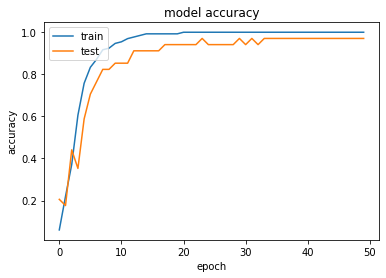

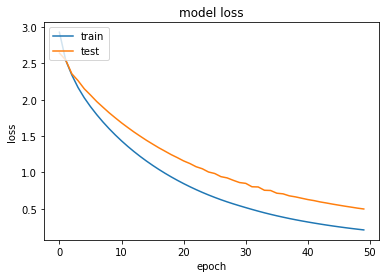

In [20]:
PlotHistory(history0)

In [22]:
model_fc = Sequential()
model_fc.add(Flatten(input_shape=features_train.data.shape[1:]))
model_fc.add(Dense(512,activation='relu'))
model_fc.add(Dropout(0.3))
model_fc.add(Dense(256,activation='relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(nub_classes, activation='softmax'))
model_fc.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 15)                3855      
                                                                 
Total params: 12,980,751
Trainable params: 12,980,751


In [23]:
model_fc.compile(loss=losses.categorical_crossentropy, optimizer=RMSprop(lr=lr), metrics=['accuracy'])

history = model_fc.fit(features_train, train_labels,batch_size=166,epochs=epochs, verbose=1,\
                    validation_data=(features_valid, valid_labels)) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/50
1/1 [==============================] - 1s 838ms/step - loss: 2.9696 - accuracy: 0.0379 - val_loss: 2.8255 - val_accuracy: 0.0294
Epoch 2/50
1/1 [==============================] - 0s 59ms/step - loss: 2.7024 - accuracy: 0.1894 - val_loss: 2.6517 - val_accuracy: 0.2059
Epoch 3/50
1/1 [==============================] - 0s 58ms/step - loss: 2.4939 - accuracy: 0.2197 - val_loss: 2.0782 - val_accuracy: 0.4412
Epoch 4/50
1/1 [==============================] - 0s 56ms/step - loss: 2.2428 - accuracy: 0.3485 - val_loss: 2.2036 - val_accuracy: 0.2941
Epoch 5/50
1/1 [==============================] - 0s 57ms/step - loss: 1.9807 - accuracy: 0.3939 - val_loss: 1.6630 - val_accuracy: 0.6765
Epoch 6/50
1/1 [==============================] - 0s 56ms/step - loss: 1.6841 - accuracy: 0.5303 - val_loss: 1.6713 - val_accuracy: 0.5588
Epoch 7/50
1/1 [==============================] - 0s 57ms/step - loss: 1.4333 - accuracy: 0.6515 - val_loss: 1.4516 - val_accuracy: 0.7059
Epoch 8/50
1/1 [==========

In [24]:
score = model_fc.evaluate(features_valid, valid_labels, verbose=0)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])


Test score: 0.11836978793144226
Test accuracy: 1.0


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


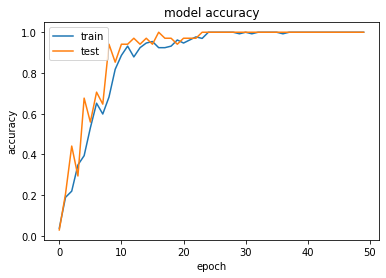

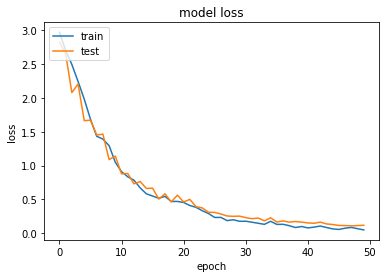

In [25]:
PlotHistory(history)

# Inferência

In [26]:
X,y=GetDataTest()

Found 166 images belonging to 15 classes.


In [27]:
def eval_model(inp, correc_logit):
    vect  = model.predict(inp[np.newaxis,:,:,:])
    logit = model_fc.predict(vect)        # fazendo a predicao
    cls = np.argmax(logit,1)[0]           # classe preditica
    correc_cls = np.argmax(correc_logit)  # classe correta
    print("previsão sujeito: " + str(cls) )
    print("correct sujeito: " + str(correc_cls)) 
    plt.imshow(inp)
    plt.axis("off")
    plt.show()

previsão sujeito: 2
correct sujeito: 2


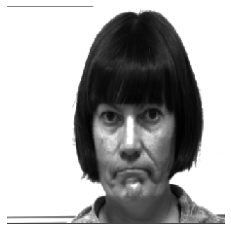

In [41]:
ind=randint(0,166)
eval_model(X[ind], y[ind])

## Fine Tuning

A diferença é que está também treinar algumas das últimas camadas convolutiva, e treinar a rede resultante com uma taxa de aprendizagem baixa.

## Outras redes CCN
    AlexNet  (2012)
    ZF Net (2013)
    R-CNN (2013)
    GoogLeNet (2015)
    Microsoft ResNet (2015)
    Fast R-CNN (2015)
    Faster R-CNN (2015)

https://adeshpande3.github.io/adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html